## Qiskitを用いた量子化学計算

### 1. 基本的なVQE計算

基本的なライブラリのインポート

In [1]:
# !pip install h5py==2.10.0
# !pip install pyscf
# !pip install qiskit
import numpy as np
# Import standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.providers.aer import StatevectorSimulator
from qiskit.utils import QuantumInstance
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.ibmq import least_busy

# Load your IBM Quantum account(s)
provider = IBMQ.load_account()

量子化学計算を実行するためにQiskit Nature librariesのインポート

In [2]:
# Import Qiskit libraries for VQE
from qiskit.algorithms import NumPyMinimumEigensolver, VQE
from qiskit.algorithms.optimizers import COBYLA, SLSQP, L_BFGS_B, SPSA
# Import Qiskit Nature libraries
from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper
# from qiskit_nature.transformers import ActiveSpaceTransformer
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer
from qiskit_nature.algorithms import VQEUCCFactory, GroundStateEigensolver
from qiskit_nature.circuit.library import HartreeFock, UCCSD, PUCCD
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)
from qiskit_nature.properties.second_quantization.electronic import ParticleNumber
from qiskit_nature.runtime import VQEClient

分子の情報を入力。
このステップは外部プログラムに依存するため注意すること。
ここではPySCFプログラムを用いてHartree–Fock計算を行う。

量子化学計算を実行する上で、設定が必要となる代表的なパラメータ: 
(使う外部プログラムによってパラメータの入力の仕方に違いがあることを留意すること。)
1. 分子を構成する原子の種類(atomic label)とその位置（デカルト座標）
2. 分子の電荷 (-1: 陰イオン, +1: 陽イオン, 0: 中性分子)
3. スピン多重度 (spin multiplicity): (1:一重項(singlet), 2:二重項(doublet), 3:三重項(triplet), .....)
4. 基底関数(Basis set):  (sto-3g, minao, 6-31g, cc-pvdz)

分子の情報を入力する(molecule)。そして、PySCFを使うようにdriverを設定。

In [3]:
# Setup the molecule
molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)
# Initiate the PySCF driver (for setup of quantum chemical calculations and Hartee-Fock calculation)
# specify driver
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

PySCFを用いてHartree–Fock計算を実行し、最適化した軌道係数を用いて第二量子化ハミルトニアンを構築する。 
ElectronicStructureProblemを使い、Hartree–Fock計算を実行。
得られるハミルトニアンをFermionOperatorに変換。

In [4]:
# Perform the setup calculation using PySCF and retrieve data from the calculations
es_problem = ElectronicStructureProblem(driver)
# Get the second quantized Hamiltonian
second_q_op = es_problem.second_q_ops()
print(second_q_op[0])

Fermionic Operator
register length=4, number terms=14
  (0.18093119978423106+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.18093119978423128+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.18093119978423128+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.18093119978423144+0j) * ( -_0 +_1 -_2 +_3  ...


ハミルトニアンをqubitにマッピングする (Jordan-Wigner変換)。

In [5]:
qubit_converter = QubitConverter(mapper=JordanWignerMapper())
qubit_op = qubit_converter.convert(second_q_op[0])
print(qubit_op)

-0.8105479805373281 * IIII
- 0.22575349222402358 * ZIII
+ 0.17218393261915543 * IZII
+ 0.12091263261776633 * ZZII
- 0.22575349222402358 * IIZI
+ 0.17464343068300436 * ZIZI
+ 0.16614543256382414 * IZZI
+ 0.17218393261915543 * IIIZ
+ 0.16614543256382414 * ZIIZ
+ 0.16892753870087904 * IZIZ
+ 0.12091263261776633 * IIZZ
+ 0.04523279994605781 * XXXX
+ 0.04523279994605781 * YYXX
+ 0.04523279994605781 * XXYY
+ 0.04523279994605781 * YYYY


同様にParity mappingを使ってマップするqubitの数を二個削減する（計算コストの削減）。

In [6]:
qubit_converter2 = QubitConverter(mapper = ParityMapper(), two_qubit_reduction=True)
qubit_op2 = qubit_converter2.convert(second_q_op[0], num_particles=es_problem.num_particles)
print(qubit_op2)

-1.0523732457728605 * II
+ (-0.39793742484317884+1.3877787807814457e-17j) * ZI
+ (0.39793742484317884-2.7755575615628914e-17j) * IZ
+ (-0.011280104256235116+1.3877787807814457e-17j) * ZZ
+ (0.18093119978423114-3.469446951953614e-18j) * XX


まずは、参照値となる厳密な値を求めるためのセットアップ。

In [7]:
# Set the solver for the exact value
numpy_solver = NumPyMinimumEigensolver()

計算の実行。

In [8]:
calc = GroundStateEigensolver(qubit_converter, numpy_solver)
res = calc.solve(es_problem)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030202
  - computed part:      -1.857275030202
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035753
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.3889487]
    - computed part:      [0.0  0.0  1.3889487]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


次にVQE計算をセットアップ。
最適化のアルゴリズム(optimizer)、スピン軌道（分子軌道の数）、電子の数（alpha, beta）を入力
初期状態としてHartree–Fockの電子配置(| 01 01> (Qiskitではalphaのスピン軌道の入力が先。それらを全て入力した後にbetaのスピン軌道を入力。))
次に試行波動関数を生成するためのansatzを指定。
ここでは、クラスター展開法の一電子励起と二電子励起を考慮したUnitary Coupled Custer Singles & Doubles (UCCSD)を用いる。
上記の情報を入力にしてVQE solverを設定。

In [9]:
# Set the optimizer (COBYLA, L_BFGS_B (L-BFGS-B), and etc.)  
# See https://github.com/Qiskit/qiskit-terra/tree/main/qiskit/algorithms/optimizers
optimizer = SLSQP(maxiter=100) 

# Set number of spin-orbitals
num_spin_orbitals=4
# Set the number of particles
num_particles=(1,1)

# Set the initial state as the Hartree-Fock state | 1100 > or | 01 01 > in Qiskit convention
initial_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

# Set the UCCSD ansatz
ansatz = UCCSD(qubit_converter,num_particles,num_spin_orbitals,initial_state=initial_state,)

# Set the VQE solver
vqe_solver = VQE(ansatz=ansatz,optimizer=optimizer,
            quantum_instance=QuantumInstance(backend=Aer.get_backend("statevector_simulator")),)

Ground state eigensolverを用いてVQE計算の実行。

In [10]:
from qiskit_nature.algorithms import GroundStateEigensolver
# Perform the VQE calculation using the Ground state eigensolver
calc = GroundStateEigensolver(qubit_converter, vqe_solver)
res = calc.solve(es_problem)
print(res)

=== GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -1.857275030144
  - computed part:      -1.857275030144
~ Nuclear repulsion energy (Hartree): 0.719968994449
> Total ground state energy (Hartree): -1.137306035695
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 2.000 S: 0.000 S^2: 0.000 M: -0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  1.3889487]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  1.38894876]
    - computed part:      [0.0  0.0  1.38894876]
  > Dipole moment (a.u.): [0.0  0.0  -0.00000006]  Total: 0.00000006
                 (debye): [0.0  0.0  -0.00000014]  Total: 0.00000014
 


### 2. ポテンシャルエネルギー曲線の構築

水素分子の水素原子間距離を伸ばしつつ、分子のエネルギーを計算する。

In [11]:
h2_length = np.arange(0.5, 2.5, 0.1)
hf_energy_list=[]
uccsd_energy_list=[]
for bond_length in h2_length:
    molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                                  ['H', [0., 0., bond_length]]],
                         charge=0, multiplicity=1)
    driver = ElectronicStructureMoleculeDriver(
        molecule, basis="sto6g", driver_type=ElectronicStructureDriverType.PYSCF
    )
    # driver = PySCFDriver(molecule = molecule, unit=UnitsType.ANGSTROM, basis='sto6g')
    es_problem = ElectronicStructureProblem(driver)
    qubit_converter = QubitConverter(mapper = ParityMapper(), two_qubit_reduction=True)
    quantum_instance = QuantumInstance(backend = Aer.get_backend('statevector_simulator'))
    vqe_solver = VQEUCCFactory(quantum_instance)
    calc = GroundStateEigensolver(qubit_converter, vqe_solver)
    res = calc.solve(es_problem)
    hf_energy_list += [res.hartree_fock_energy] 
    uccsd_energy_list += [res.total_energies[0]] 

結合距離に対して、分子のエネルギーをプロット。
ここでは、UCCSDは乖離極限に向かって収束する（これが正しい描像）ことを確認する。
それに対して、Hartree-Fock法は異なる挙動を示すことにも留意。 

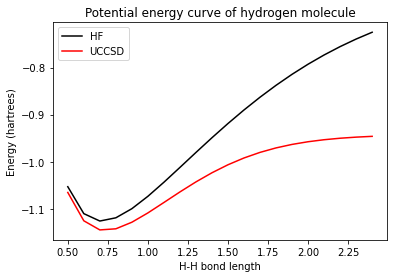

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(h2_length,hf_energy_list,color='black',label='HF')
plt.plot(h2_length,uccsd_energy_list,color='red',label='UCCSD')
plt.title("Potential energy curve of hydrogen molecule")
plt.xlabel("H-H bond length")
plt.ylabel("Energy (hartrees)")
plt.legend()

### 3. 問題サイズを小さくし、計算コストを削減

### 計算コスト削減前の参照値 (5-10分ほどかかる)

In [13]:
# define molecule
molecule = Molecule(geometry=[['Li', [0., 0., 0.]],
                              ['H',  [0., 0., 2.5]]],
                        charge=0, 
                        multiplicity=1)

# specify driver
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

# define electronic structure problem
problem = ElectronicStructureProblem(driver)

# construct qubit converter (Jordan-Wigner)
qubit_converter = QubitConverter(mapper=JordanWignerMapper())

# Set the optimizer (COBYLA, L_BFGS_B (L-BFGS-B), and etc.)  
# See https://github.com/Qiskit/qiskit-terra/tree/main/qiskit/algorithms/optimizers
optimizer = SLSQP(maxiter=100) 

# Set number of spin-orbitals
num_spin_orbitals=12
# Set the number of particles
num_particles=(2,2)

# Set the initial state as the Hartree-Fock state | 1100 > or | 01 01 > in Qiskit convention
initial_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

# Set the UCCSD ansatz
ansatz = UCCSD(qubit_converter=qubit_converter,num_particles=num_particles,num_spin_orbitals=num_spin_orbitals,initial_state=initial_state,)

# Set the VQE solver
vqe_solver = VQE(ansatz=ansatz,optimizer=optimizer,
            quantum_instance=QuantumInstance(backend=Aer.get_backend("statevector_simulator")),)

calc = GroundStateEigensolver(qubit_converter, vqe_solver)
res_UCCSD = calc.solve(problem)
lih_uccsd_energy= res_UCCSD.total_energies[0]
lih_hf_energy = res_UCCSD.hartree_fock_energy
print('LiH HF energy = ', lih_hf_energy)
print('LiH UCCSD energy = ', lih_uccsd_energy)

LiH HF energy =  -7.770873669221905
LiH UCCSD energy =  -7.8236790754197605


次に厳密な値も計算しておく。

In [14]:
np_solver = NumPyMinimumEigensolver()
np_groundstate_solver = GroundStateEigensolver(qubit_converter, np_solver)

np_result = np_groundstate_solver.solve(problem)

target_energy = np.real(np_result.eigenenergies + np_result.nuclear_repulsion_energy)[0]
print('LiH exact energy:', target_energy)

LiH exact energy: -7.823723883467717


### Ansatzの変更
ここでは、UCCSDよりも計算コストが少ない、ペアの二電子励起のみを考慮するPUCCD(Pair Unitary Coupled Cluster Doubles)を用いる。

In [15]:
# define electronic structure problem
problem = ElectronicStructureProblem(driver)

# construct qubit converter (Jordan-Wigner)
qubit_converter = QubitConverter(mapper=JordanWignerMapper())

# Set the optimizer (COBYLA, L_BFGS_B (L-BFGS-B), and etc.)  
# See https://github.com/Qiskit/qiskit-terra/tree/main/qiskit/algorithms/optimizers
optimizer = SLSQP(maxiter=100) 

# Set number of spin-orbitals
num_spin_orbitals=12
# Set the number of particles
num_particles=(2,2)

# Set the initial state as the Hartree-Fock state | 1100 > or | 01 01 > in Qiskit convention
initial_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

# Set the PUCCD ansatz (You can also try changing PUCCD to SUCCD)
ansatz = PUCCD(qubit_converter=qubit_converter,num_particles=num_particles,num_spin_orbitals=num_spin_orbitals,initial_state=initial_state,)

# Set the VQE solver
vqe_solver = VQE(ansatz=ansatz,optimizer=optimizer,
            quantum_instance=QuantumInstance(backend=Aer.get_backend("statevector_simulator")),)

calc = GroundStateEigensolver(qubit_converter, vqe_solver)
res_PUCCD = calc.solve(problem)
lih_puccd_energy= res_PUCCD.total_energies[0]
print('LiH PUCCD energy = ', lih_puccd_energy)

LiH PUCCD energy =  -7.802918395775962


### Active spaceを設定し、問題サイズを小さくする
ActiveSpaceTransormerを用いてActive spaceを設定。
ここでは、スピン軌道を元々あった12から6に減らしている（空間軌道は6から3に）。

In [16]:
# Run PySCF to get the parameters for the molecule
properties = driver.run()

particle_number = properties.get_property(ParticleNumber)
    
# Specify active space transformation (You can also try changing the number of orbitals)
active_space_trafo = ActiveSpaceTransformer(num_electrons=particle_number.num_particles,
                                            num_molecular_orbitals=3)
    
# Define electronic structure problem
problem = ElectronicStructureProblem(driver, transformers=[active_space_trafo])

# Construct qubit converter (parity mapping + 2-qubit reduction)
qubit_converter = QubitConverter(mapper=JordanWignerMapper())

# If you change num_molecular_orbitals, set num_spin_orbitals = num_molecular_orbitals*2 
num_spin_orbitals = 6
num_particles=(2,2)

# Set the initial state as the Hartree-Fock state | 1100 > or | 01 01 > in Qiskit convention
initial_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)
# Set the UCCSD ansatz
ansatz = UCCSD(qubit_converter=qubit_converter,num_particles=num_particles,num_spin_orbitals=num_spin_orbitals,initial_state=initial_state,)

# Set the VQE solver
vqe_solver = VQE(ansatz=ansatz,optimizer=optimizer,
            quantum_instance=QuantumInstance(backend=Aer.get_backend("statevector_simulator")),)

calc = GroundStateEigensolver(qubit_converter, vqe_solver)
res_UCCSD_active = calc.solve(problem)

lih_uccsd_energy_active= res_UCCSD_active.total_energies[0]
print('LiH UCCSD energy with active space = ', lih_uccsd_energy_active)

LiH UCCSD energy with active space =  (-7.773617562048176+0j)


これまでの計算結果を比較する。
計算コストと計算精度を比較し、計算の費用対効果を考察する。

In [17]:
print('LiH HF energy = ', lih_hf_energy)
print('LiH UCCSD energy with active space = ', lih_uccsd_energy_active.real)
print('LiH PUCCD energy = ', lih_puccd_energy)
print('LiH UCCSD energy = ', lih_uccsd_energy)
print('LiH exact energy:', target_energy)

LiH HF energy =  -7.770873669221905
LiH UCCSD energy with active space =  -7.773617562048176
LiH PUCCD energy =  -7.802918395775962
LiH UCCSD energy =  -7.8236790754197605
LiH exact energy: -7.823723883467717


## 4. Qiskit Runtimeを用いた実機でのシミュレーション

シミュレーションを実行するための量子コンピュータを設定。
ここでは、もっとも混んでいないマシンを指定。

In [18]:
# Set the provider
provider = IBMQ.get_provider(hub='ibm-q')
# Choose the least busy hardware
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", backend)

Running on current least busy device:  ibmq_belem


このようにコールバック関数を指定することも可能。なお、このnotebookではこの機能は用いていない。

In [19]:
intermediate_info = {
    'nfev': [],
    'parameters': [],
    'energy': [],
    'stddev': []
}

def callback(nfev, parameters, energy, stddev):
    intermediate_info['nfev'].append(nfev)
    intermediate_info['parameters'].append(parameters)
    intermediate_info['energy'].append(energy)
    intermediate_info['stddev'].append(stddev)

ノイズのある実機でシミュレーションを実行するので、measurement_error_mitigation=True として、測定エラーを軽減する。

In [20]:
measurement_error_mitigation = True

先ほど実行した H<sub>2</sub> 分子のシミュレーションを実機にて実行する。
最後の行でQiskit Runtimeを用いてVQEを実行するよう設定する。

In [21]:
from qiskit_nature.runtime import VQEProgram
# Set the optimizer (consider using an optimizer suitable for noisy experiment)
optimizer = {'name': 'SPSA',
             'maxiter': 200}

# Setup the molecule
molecule = Molecule(geometry=[['H', [0., 0., 0.]],
                              ['H', [0., 0., 0.735]]],
                     charge=0, multiplicity=1)
# Initiate the PySCF driver (for setup of quantum chemical calculations and Hartee-Fock calculation)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)
es_problem = ElectronicStructureProblem(driver)

# If you have time, it may be worth trying the same experiment with 4-qubits 
# (Change the qubit converter)
# qubit_converter = QubitConverter(mapper=JordanWignerMapper())
qubit_converter = QubitConverter(mapper = ParityMapper(), two_qubit_reduction=True)

second_q_op = es_problem.second_q_ops()    

qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)  
    
# Check you setup with the simulator before conducting the experiment
# quantum_instance=QuantumInstance(backend = Aer.get_backend('statevector_simulator'))
quantum_instance = QuantumInstance(shots=4096,backend=backend)

# Set number of spin-orbitals
num_spin_orbitals=4
# Set the number of particles
num_particles=(1,1)

# Set the initial state as the Hartree-Fock state | 1100 > or | 01 01 > in Qiskit convention
initial_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

# Set the UCCSD ansatz
ansatz = UCCSD(qubit_converter,num_particles,num_spin_orbitals,initial_state=initial_state,)

runtime_vqe = VQEClient(ansatz=ansatz,
                         optimizer=optimizer,
                         provider=provider,
                         backend=backend,
                         shots=4096,
                         measurement_error_mitigation=True,
                         callback=callback)

In [22]:
runtime_vqe_groundstate_solver = GroundStateEigensolver(qubit_converter, runtime_vqe)
runtime_vqe_result = runtime_vqe_groundstate_solver.solve(es_problem)

In [23]:
print(
    "Energy:",
    np.real(runtime_vqe_result.eigenenergies + runtime_vqe_result.nuclear_repulsion_energy)[0],
)

Energy: -1.0465516356323743


VQEClientを用いると最適化プロセスにおける経過にアクセスすることが可能となる。なお、SPSAとQN-SPSAの最適化アルゴリズムでのみ、その機能を使うことができるので注意すること。そのデータはground state solverのraw_resultより参照できる。

In [24]:
runtime_result = runtime_vqe_result.raw_result
history = runtime_result.optimizer_history
loss = history["loss"]


計算過程をプロットする。VQEにおいて分子のエネルギーがどのように収束しているかを調べることができる。

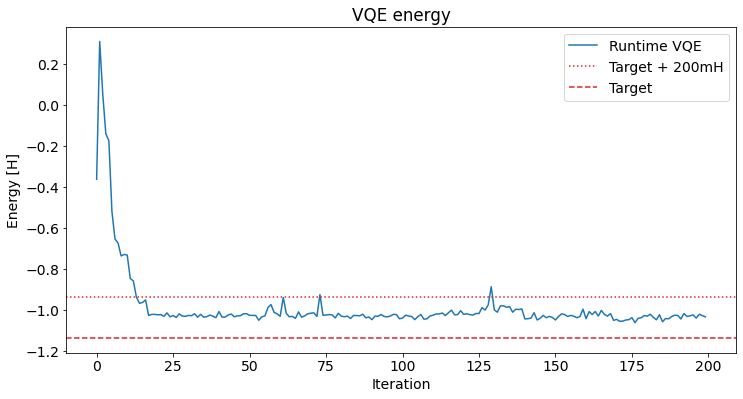

In [25]:
import matplotlib.pyplot as plt
target_energy=-1.137306035753
plt.rcParams["font.size"] = 14

# plot loss and reference value
plt.figure(figsize=(12, 6))
plt.plot(loss + runtime_vqe_result.nuclear_repulsion_energy, label="Runtime VQE")
plt.axhline(y=target_energy + 0.2, color="tab:red", ls=":", label="Target + 200mH")
plt.axhline(y=target_energy, color="tab:red", ls="--", label="Target")

plt.legend(loc="best")
plt.xlabel("Iteration")
plt.ylabel("Energy [H]")
plt.title("VQE energy");

Qiskitのバージョンのチェック

In [26]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright